# In this tutorial we will build basic CNN for image classification and then perform few test to understand overall working on CNN.
Author :- Dr. Ankur Mali -- (Intro to DL - USF)
* We will define our model and learn how to use keras module to build custom layers
* We will also design our own training loop, that is identical to model.fit in Keras.
* The aim of this excercise is to teach, how to use exisiting Tensorflow API to construct our own module and integrate it with tf.keras API.

In [142]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
from typing import List, Optional, Sequence

np.random.seed(10000-2000)

#Things to do
* Remember to Normalize your data and create validation split from train set.
* Learn about tf.data, tf.slices and also tf.records

In [143]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Add Gaussian noise to the test samples
# noise_stddev = 0.05
# x_test = x_test + np.random.normal(loc=0, scale=noise_stddev, size=x_test.shape)
# x_test = np.clip(x_test, 0, 255)

x_val = x_train[45000:50000]
y_val = y_train[45000:50000]
x_train = x_train[0:45000]
y_train = y_train[0:45000]
x_train = x_train.astype(np.float32).reshape(-1,32,32,3) / 255.0
x_val = x_val.astype(np.float32).reshape(-1,32,32,3) / 255.0
x_test = x_test.astype(np.float32).reshape(-1,32,32,3) / 255.0
y_train = tf.one_hot(y_train, depth=10)
y_val = tf.one_hot(y_val, depth=10)
y_test = tf.one_hot(y_test, depth=10)

#Add the data augmentation technique
#datagen = ImageDataGenerator(horizontal_flip=True)

# datagen = ImageDataGenerator(
#     horizontal_flip=True,
#     vertical_flip=True,  # Add vertical flip
#     rotation_range=30,  # Add rotation (in degrees, e.g., 20 degrees)
#     #zoom_range=0.2,
#     #brightness_range=[0.8, 1.2],  # Adjust brightness by 20%
# )

# datagen.fit(x_train)

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
train_dataset_full = train_dataset.shuffle(buffer_size=1024).batch(len(train_dataset))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)
print(len(train_dataset))
print(len(test_dataset))

(45000, 32, 32, 3)
(10000, 32, 32, 3)
(5000, 32, 32, 3)
352
79


# Create your custom CNN class
* Convolution layers has 4D weights of size (h,w,input_feature, output_feature), where h=height of your kernel and w = width of our kernel. If you add batches then it is 5D.
* Now your model will convolve across your input feature map with kernel and create output feature map, that is then passed to next layer.
* As we have learned in our prior class, to initialize your weights, we use tf.Variable(weight_init(size)), tf.keras.layers.Conv2D will do this for you. Play with the function and see how it works for your problem.
* Few important concepts, learn to save your model after every k epochs and start re-training from last checkpoint. This is very useful, and you don't need to retrain your model from scratch.


In [144]:
class ImageRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None, checkpoint_prefix = None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(256, 3, padding='same', activation=None)
        self.conv2 = tf.keras.layers.Conv2D(256, 3,padding='same', activation=None)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(256, 3, padding='same', activation=None) #128
        self.conv4 = tf.keras.layers.Conv2D(256, 3, padding='same', activation=None)#64
        self.conv8 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
        
        # Add an additional convolutional layer
        self.conv5 = tf.keras.layers.Conv2D(256, 3, padding='same', activation=None)#128

        # Add the AveragePooling2D layer
        self.avg_pool = tf.keras.layers.AveragePooling2D(pool_size=(1, 1))

        # Batch normalization layers
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.batch_norm4 = tf.keras.layers.BatchNormalization()
        self.batch_norm5 = tf.keras.layers.BatchNormalization()


        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        self.checkpoint_prefix = checkpoint_prefix
        self.acc = tf.keras.metrics.Accuracy()

    #@tf.function
    def predict(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
        """
        x = self.conv1(images)
        x = self.batch_norm1(x)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = tf.nn.relu(x)
        x = self.pool1(x)
       

        # Apply the additional convolutional layer
        x = self.conv5(x)
        x = self.batch_norm5(x)
        x = tf.nn.relu(x)
        x = self.pool1(x)

        x = self.conv8(x)
        x = self.avg_pool(x)
        x = tf.reshape(x, (-1, 1, 10))
        return x


    @tf.function
    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
  
        preds = self.predict(images, training)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss

    @tf.function
    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)

    
    @tf.function
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=False)
            # Restore the variables of the model
            saver = tf.compat.v1.train.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    @tf.function
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        
        tf.compat.v1.train.Saver(self.variables).save(save_path=self.checkpoint_directory, 
                                       global_step=global_step)   
        return None
    
    @tf.function
    def compute_accuracy_2(self, images, targets):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            
            # Predict the probability of each class
            logits = self.predict(images, training=False)
            # Select the class with the highest probability
            
            logits = tf.nn.softmax(logits)
            logits = tf.reshape(logits, [-1, 10])
            targets = tf.reshape(targets, [-1,10])
            preds = tf.argmax(logits, axis=1)
            goal = tf.argmax(targets, axis=1)
            self.acc.update_state(goal, preds)
            # Compute the accuracy
            result = self.acc.result()
            #result = self.acc.result().numpy()
        return result


    def fit_fc(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False, ckpoint=None):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999.99
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        acc_train = tf.keras.metrics.Mean('train_acc')
        acc_val = tf.keras.metrics.Mean('val_acc')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        self.history['train_acc'] = []
        self.history['val_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                #training_data_x = training_data.shuffle(buffer_size=1024).batch(128)
                for step, (images, target) in enumerate(training_data):
                    grads = self.grads_fn(images, target, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for step, (images, target) in enumerate(training_data):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_train(accuracy)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result())
                self.history['train_acc'].append(acc_train.result())
                #self.history['train_loss'].append(train_loss.result().numpy())
                #self.history['train_acc'].append(acc_train.result().numpy())
                # Reset metrics
                
                
                # Compute the loss on the eval data after one epoch
                for step, (images, target) in enumerate(eval_data):
                    loss = self.loss_fn(images, target, False)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result())
                self.history['val_acc'].append(acc_val.result())
                # self.history['eval_loss'].append(eval_loss.result().numpy())
                # self.history['val_acc'].append(acc_val.result().numpy())
                # Reset metrics
                # print(train_loss.result())
                # print('Train loss at epoch %d: ' %(i+1), train_loss.result())
                # print('Train Acc at epoch %d: ' %(i+1), acc_train.result())
                    
                # print('Eval loss at epoch %d: ' %(i+1), eval_loss.result())
                # print('Eval Acc at epoch %d: ' %(i+1), acc_val.result())
                
                train_loss.reset_states()
                acc_train.reset_states()
                eval_loss.reset_states()
                acc_val.reset_states()
                #Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Train loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Train Acc at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])
                    print('Eval Acc at epoch %d: ' %(i+1), self.history['val_acc'][-1])
                    print('Model Saved')
                    ckpoint.save(file_prefix=self.checkpoint_prefix)
                    #self.save_model()

                # Check for early stopping
                count = 0 
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break


    def predict_fc(self, test_data):
      # Initialize classes to update the mean loss of train and eval
        test_loss = tf.keras.metrics.Mean('train_loss')
        acc_test = tf.keras.metrics.Mean('test_acc')
        
        
        # Begin training
        with tf.device(self.device):
          for step, (images, target) in enumerate(test_data):
              loss = self.loss_fn(images, target, False)
              accuracy = self.compute_accuracy_2(images,target)
              acc_test(accuracy)
              test_loss(loss)
        print("test_accuracy %d", acc_test.result())
        print("test_loss %d", test_loss.result())
            
                
                



In [145]:
import os
# Specify the path where you want to save/restore the trained variables.
#sample_data
checkpoint_directory = '/content/models_checkpoints/'
#checkpoint_directory = "/tmp/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")
# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory, checkpoint_prefix = checkpoint_prefix)


### This example is modified to work with Tensorflow > 2.6

## Create checkpoint to save your model
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
## Now store the initial checkpoint - at random initialization
checkpoint.save(file_prefix=checkpoint_prefix)

'/content/models_checkpoints/ckpt-1'

In [146]:
# Train model
# Pass the saver object to save model each epoch -- You can change the rule/scheme for saving the model
model.fit_fc(train_dataset, val_dataset, optimizer, num_epochs=20, 
          early_stopping_rounds=2, verbose=2, train_from_scratch=True, ckpoint = checkpoint)

Train loss at epoch 1:  tf.Tensor(1.3010024, shape=(), dtype=float32)
Train Acc at epoch 1:  tf.Tensor(0.5285584, shape=(), dtype=float32)
Eval loss at epoch 1:  tf.Tensor(1.3268251, shape=(), dtype=float32)
Eval Acc at epoch 1:  tf.Tensor(0.53361404, shape=(), dtype=float32)
Model Saved
Train loss at epoch 2:  tf.Tensor(0.8955981, shape=(), dtype=float32)
Train Acc at epoch 2:  tf.Tensor(0.5731321, shape=(), dtype=float32)
Eval loss at epoch 2:  tf.Tensor(0.9411485, shape=(), dtype=float32)
Eval Acc at epoch 2:  tf.Tensor(0.6047636, shape=(), dtype=float32)
Model Saved
Train loss at epoch 4:  tf.Tensor(0.5991747, shape=(), dtype=float32)
Train Acc at epoch 4:  tf.Tensor(0.66978544, shape=(), dtype=float32)
Eval loss at epoch 4:  tf.Tensor(0.7850724, shape=(), dtype=float32)
Eval Acc at epoch 4:  tf.Tensor(0.6859572, shape=(), dtype=float32)
Model Saved
Train loss at epoch 6:  tf.Tensor(0.34536904, shape=(), dtype=float32)
Train Acc at epoch 6:  tf.Tensor(0.7240921, shape=(), dtype=flo

In [147]:
model.predict_fc(test_dataset)

test_accuracy %d tf.Tensor(0.8633191, shape=(), dtype=float32)
test_loss %d tf.Tensor(1.7783381, shape=(), dtype=float32)


In [148]:
# Now let's try to restore the model from latest checkpoint
# In this case load latest checkpoint -- 7
checkpoint_prefix_restore = os.path.join(checkpoint_directory, "ckpt-7")
checkpoint.restore(checkpoint_prefix_restore)

In [149]:
## Load the model and make prediction
c_model = checkpoint.model
c_model.predict_fc(test_dataset)

test_accuracy %d tf.Tensor(0.794475, shape=(), dtype=float32)
test_loss %d tf.Tensor(1.250192, shape=(), dtype=float32)


In [150]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_confusion_matrix(
    true: np.ndarray,
    pred: np.ndarray,
    labels: Optional[List[str]] = None,
    normalize: str = "true",
    figsize: Sequence[int] = (5, 4),
) -> np.ndarray:
    """Plot confusion matrix
    Args:
        true (numpy.array): true label
        pred (numpy.array): predicted label
        labels (List[str]), default=None] list of label names
        normalize (str, default="true): whether to normalize scores, chosen from "true" or "false"
    Returns:
        fig: figure of confusion matrix
    """
    cm = confusion_matrix(true, pred, normalize=normalize)
    fig = plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        cmap="Reds",
        square=True,
        vmin=0,
        vmax=1.0,
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Normalized confusion matrix")

    plt.close()
    return fig
     

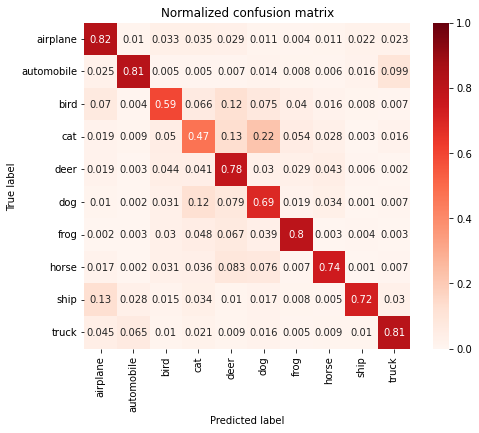

In [151]:
y_true = []
y_pred = []

for img, target in test_dataset:
  preds = model.predict(img, training = False)
  preds = tf.nn.softmax(preds)
  y_pred.extend(np.argmax(preds.numpy().reshape(-1, 10), axis=1))

  y_true.extend(np.argmax(target.numpy().reshape(-1, 10), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
plot_confusion_matrix(y_true, y_pred, labels=class_names, figsize=(8, 6))

## Now let's define various tasks

Given we have provided entire training scripts and code that shows how to run a Convolution neural network on cifar-10 datasets. For this assignment the class will work on 3 tasks,

## Very important - If you start late, you won't be able to finish this assignment. 

## Task-1
1. Find the best hyper-parameter for above model --- You have to add minimum one additional conv layer to above model -- you can reduce the filter_size and input features. But not the number of layers
2. It is very important you Keep track of your validation loss to select the best model -- You will train your model for minimum 15 epochs.
3. There is flexibility to change your network hyperparameters, such as optimizer, learning rate, activation function, filter size, batch size, etc
4. Show minimum 3 settings or comparsion.
5. Once you have the best hyper-parameter, then run your model for 5 trials, report mean accuracy and standard error (both metrics are calculated over your accuracy).
6. Whenever in doubt, simply ask.

## Task-2 - Data Augmentation
1. Rotate Image at an arbitrary angle (15,45, 60 and so on)
2. Crop Image from the center and resize
3. Flip Image from left to right (Create a mirror image)
4. Choose any two augmentation approach and report your performance. 
5. Remember you will optimize your model, try to beat accuracy reported on task-1. Once you find the best settings run your experiments for 5 trials, report mean accuracy and standard error (both metrics are calculated over your accuracy)
6. You will only augment your train set, test and validation set are untouched. 

## Task-3- Adversial Samples
1. Now you will add small gaussian noise to your test samples(one can use standard deviation = 0.05, while using random_normal)
2. Take model from task-1, get the performance on this adversial samples. For this One must report confusion matrix on original test samples and adversial samples. (The code is already provided in Github or else one can use sklearn function). Remember your confusion matrix is the product of 5 trials, in other words you will pass mean values or mean prediction to your function
3. Repeat above steps for task-2
4. Report your findings.

## Rubric

## Task-1 (3 points)
1. Only one setting is reported - (-2 point)
2. No modification to original code and only reported default settings - (0 or -3 points)
3. Mean and standard error miscalculations/error - (1.2 points)
4. Result with only one trial - (-2 points)

## Task-2 (4 points)
1. No data augmentation - (- 4 points)
2. Only one data augmentation - (- 2 points)
3. Data augmentation on test and validation set - (0 or -4 points)
4. Mean and standard error miscalculations/error - (1.2 points)
5. Result with only one trial - (-2.8 points)

## Task-3 (3 points)
1. gaussian noise added on test and validation set - (0 or -3 points)
2. Result with only one trial - (-2 points)
3. Performance reported on only one task (1 or 2) - (-1.5 points)
4. No confusion matrix - (- 1.2 points)
5. Mean and standard error miscalculations/error - (1.2 points)